In [4]:
import os

# os.environ["PYSYN_CDBS"] = "/home/ruizhew/POSEIDON/inputs/stellar_grids/"
# os.environ["POSEIDON_input_data"] = "/home/ruizhew/POSEIDON/inputs/"

In [5]:
from __future__ import absolute_import, unicode_literals, print_function
from POSEIDON.high_res import *
from POSEIDON.utility import read_high_res_data_deprecate
import numpy as np
from scipy import constants
from numba import jit
from POSEIDON.core import (
    create_star,
    create_planet,
    define_model,
    make_atmosphere,
    read_opacities,
    wl_grid_constant_R,
    wl_grid_line_by_line,
    compute_spectrum,
)
from POSEIDON.constants import R_Sun
from POSEIDON.constants import R_J, M_J
import numpy as np
import matplotlib.pyplot as plt

In [6]:
# data_dir = "./data/WASP-76b-MAROON/"
# nights = ["night_1", "night_2", "night_3", "night_4", "night_5", "night_6"]
# names = [
#     "night_1_blue",
#     "night_1_red",
#     "night_2_blue",
#     "night_2_red",
#     "night_3_blue",
#     "night_3_red",
# ]
data_dir = "./data/WASP-121b/"
names = ["blue", "redl", "redu"]

In [36]:
from POSEIDON.utility import read_high_res_data_deprecate

for name in names[:]:
    data = read_high_res_data_deprecate(
        data_dir + name, method="sysrem", spectrum_type="transmission"
    )
    flux = data["data_raw"]
    wl_grid = data["wl_grid"]
    phi = data["phi"]
    transit_weight = data["transit_weight"]
    flux = remove_outliers(wl_grid, flux)
    flux = blaze_correction(flux, filter_size=(500, 100))
    uncertainties = fit_uncertainties(flux)
    prepare_high_res_data(
        data_dir,
        name,
        "transmission",
        "sysrem",
        flux,
        wl_grid,
        phi,
        uncertainties,
        transit_weight,
    )

Overwriting data at ./data/WASP-121b/blue/data_processed.hdf5
Fitting Poisson uncertainties with 5 components
Blaze correcting data with median filter size 15 and gaussian filter size 50
Filtering out systematics using SYSREM with 15 iterations
Overwriting data at ./data/WASP-121b/redl/data_processed.hdf5
Fitting Poisson uncertainties with 5 components
Blaze correcting data with median filter size 15 and gaussian filter size 50
Filtering out systematics using SYSREM with 15 iterations
Overwriting data at ./data/WASP-121b/redu/data_processed.hdf5
Fitting Poisson uncertainties with 5 components
Blaze correcting data with median filter size 15 and gaussian filter size 50
Filtering out systematics using SYSREM with 15 iterations


In [7]:
from POSEIDON.core import define_model, wl_grid_constant_R

R_s = 1.458 * R_Sun  # Stellar radius (m)
T_s = 6776  # Stellar effective temperature (K)
Met_s = 0.13  # Stellar metallicity [log10(Fe/H_star / Fe/H_solar)]
log_g_s = 4.24  # Stellar log surface gravity (log10(cm/s^2) by convention)

# Create the stellar object
star = create_star(R_s, T_s, log_g_s, Met_s, stellar_grid="phoenix")

F_s = star["F_star"]
wl_s = star["wl_star"]

# ***** Define planet properties *****#

planet_name = "WASP-121b"  # Planet name used for plots, output files etc.

R_p = 0.118 * R_s  # Planetary radius (m)
M_p = 1.157 * M_J  # Mass of planet (kg)
g_p = 10 ** (2.97 - 2)  # Gravitational field of planet (m/s^2)
T_eq = 2450  # Equilibrium temperature (K)

# Create the planet object
planet = create_planet(planet_name, R_p, mass=M_p, gravity=g_p, T_eq=T_eq)

# If distance not specified, use fiducial value
if planet["system_distance"] is None:
    planet["system_distance"] = 1  # This value only used for flux ratios, so it cancels
d = planet["system_distance"]

# %%
from POSEIDON.core import define_model, wl_grid_constant_R, make_atmosphere

# ***** Define model *****#

model_name = "Fe"  # Model name used for plots, output files etc.

bulk_species = ["H2", "He"]  # H2 + He comprises the bulk atmosphere
# param_species = ["Fe", "Cr", "Mg", "V"]
param_species = ["Fe"]

high_res_params = ["K_p", "V_sys", "W_conv", "log_a"]

model = define_model(
    model_name,
    bulk_species,
    param_species,
    PT_profile="isotherm",
    high_res_params=high_res_params,
)

wl_min = 0.37  # Minimum wavelength (um)
wl_max = 0.87  # Maximum wavelength (um)
R = 250000  # Spectral resolution of grid

wl = wl_grid_constant_R(wl_min, wl_max, R)

# Create the stellar object
star = create_star(R_s, T_s, log_g_s, Met_s, stellar_grid="phoenix")

# ***** Read opacity data *****#

opacity_treatment = "opacity_sampling"

# Define fine temperature grid (K)
T_fine_min = 2900  # 400 K lower limit suffices for a typical hot Jupiter
T_fine_max = 3100  # 2000 K upper limit suffices for a typical hot Jupiter
T_fine_step = 20  # 20 K steps are a good tradeoff between accuracy and RAM

T_fine = np.arange(T_fine_min, (T_fine_max + T_fine_step), T_fine_step)

# Define fine pressure grid (log10(P/bar))
log_P_fine_min = -12.0  # 1 ubar is the lowest pressure in the opacity database
log_P_fine_max = 2  # 100 bar is the highest pressure in the opacity database
log_P_fine_step = 0.2  # 0.2 dex steps are a good tradeoff between accuracy and RAM

log_P_fine = np.arange(
    log_P_fine_min, (log_P_fine_max + log_P_fine_step), log_P_fine_step
)

# Now we can pre-interpolate the sampled opacities (may take up to a minute)
opac = read_opacities(model, wl, opacity_treatment, T_fine, log_P_fine)

Reading in cross sections in opacity sampling mode...
H2-H2 done
H2-He done
Fe done
Opacity pre-interpolation complete.


In [25]:
param_species = ["Fe"]  # , "Cr", "Mg", "V"]
model = define_model(
    model_name,
    bulk_species,
    param_species,
    PT_profile="isotherm",
    high_res_params=high_res_params,
    # cloud_model="MacMad17",
    # cloud_type="deck",
)

# Specify the pressure grid of the atmosphere
P_min = 1.0e-12  # 0.1 ubar
P_max = 100  # 100 bar
N_layers = 100  # 100 layers

# We'll space the layers uniformly in log-pressure
P = np.logspace(np.log10(P_max), np.log10(P_min), N_layers)

# Specify the reference pressure and radius
P_ref = 1e-2  # Reference pressure (bar)
R_p_ref = R_p  # Radius at reference pressure

# log_species = [-5, -7, -4, -8]
log_species = [-5]
T = 3000

# Provide a specific set of model parameters for the atmosphere
PT_params = np.array([T])  # a1, a2, log_P1, log_P2, log_P3, T_deep
log_X_params = np.array([log_species])
# cloud_params = np.array([0])

atmosphere = make_atmosphere(
    planet,
    model,
    P,
    P_ref,
    R_p_ref,
    PT_params,
    log_X_params,
)

# Generate planet surface flux
spectrum = compute_spectrum(
    planet,
    star,
    model,
    atmosphere,
    opac,
    wl,
    spectrum_type="transmission",
)

In [26]:
import POSEIDON

data = POSEIDON.high_res.read_high_res_data(data_dir, names=names)
# spectrum = np.load("./data/WASP-76b-MAROON/" + "models/Fe.npy")
# model_wave = np.load("./data/WASP-76b-MAROON/" + "models/wave.npy")
model_wave = wl
# model_wave = pyasl.vactoair2(model_wave * 1e4) / 1e4

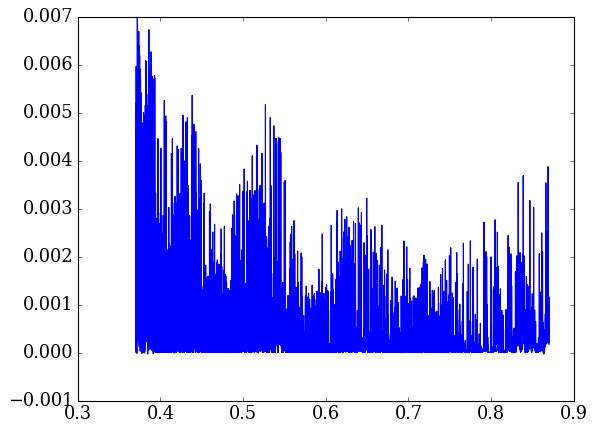

In [28]:
from scipy.ndimage import gaussian_filter1d, maximum_filter1d, minimum_filter1d

plt.plot(wl, spectrum - gaussian_filter1d(minimum_filter1d(spectrum, 2000), 1000))

In [32]:
from scipy.ndimage import gaussian_filter1d, maximum_filter1d, minimum_filter1d

Kp_range = np.arange(-300, 301, 1)
Vsys_range = np.arange(-200, 201, 1)
RV_range = np.arange(-400, 401, 1)

CCF_Kp_Vsys_all = []
CCF_phase_RV_all = []
for key in data.keys():
    CCF_Kp_Vsys, CCF_phase_RV = cross_correlate(
        Kp_range,
        Vsys_range,
        RV_range,
        model_wave,
        # spectrum - gaussian_filter1d(minimum_filter1d(spectrum, 2000), 1000),
        gaussian_filter1d(spectrum, 3),
        data[key],
    )
    CCF_Kp_Vsys_all.append(CCF_Kp_Vsys)
    CCF_phase_RV_all.append(CCF_phase_RV)
CCF_phase_RV_all = np.array(CCF_phase_RV_all)
CCF_Kp_Vsys_all = np.array(CCF_Kp_Vsys_all)

Cross correlation took 60.89285182952881 seconds
Cross correlation took 60.961483001708984 seconds
Cross correlation took 43.40769720077515 seconds


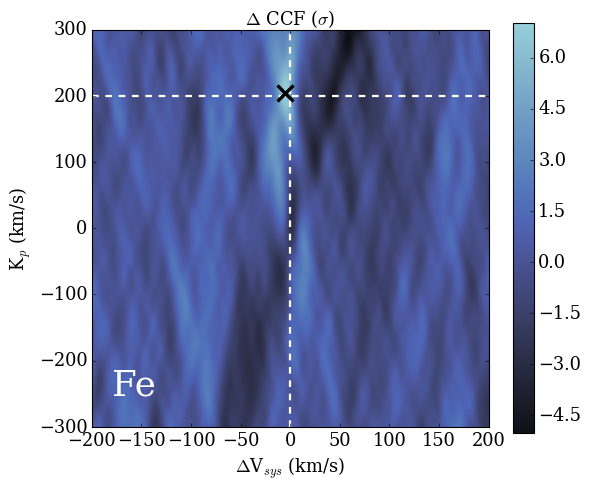

In [33]:
plot_CCF_Kp_Vsys(
    Kp_range,
    Vsys_range,
    np.sum(CCF_Kp_Vsys_all[:], axis=0),
    "Fe",
    200,
    Vsys=0,
    RM_mask_size=50,
    plot_label=True,
    savefig=False,
    plot_slice=False,
    file_path="./CC_output/WASP_121_CCF_Fe.pdf",
    cmap=cmr.get_sub_cmap("cmr.sapphire", 0.1, 0.9),
)

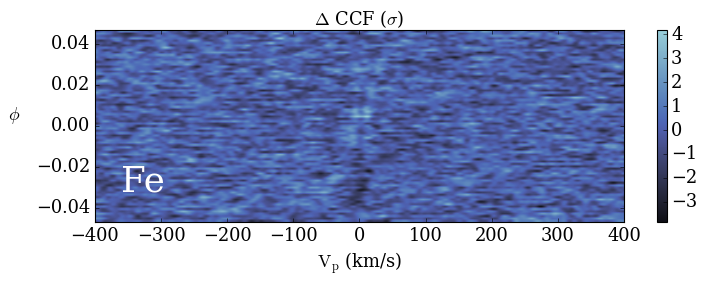

In [34]:
transit_model = data["blue"]["transit_weight"]
in_transit = transit_model != 1
phi = data["blue"]["phi"][in_transit]
plot_CCF_phase_RV(
    phi,
    RV_range,
    np.mean(CCF_phase_RV_all, axis=0)[in_transit],
    "Fe",
    plot_label=True,
    save_path="./CC_output/WASP121_CCF_phase_Fe.pdf",
    cmap=cmr.get_sub_cmap("cmr.sapphire", 0.1, 0.9),
)